In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_friedman1
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import json
from sklearn.dummy import DummyRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
#from utils_Nadja import fold_visualizer
from utils import FriedmanDataset, run_kfold_visualizer, ModelOptimizer

In [3]:
# Fill in the path where you downloaded the project or if the hole folder is open, leave it as it is. 
# Should print what in your folder is.
import os
ROOT_PATH = './'
print(os.listdir(ROOT_PATH))

['optimization_results.json', 'optimization_results1.json', 'setup_general.ipynb', 'utils.py', '__pycache__']


In [4]:
# Set number of datapoints of training and test set
n_train=1000
n_test=100000
n_iter=10
n_features = 5

In [5]:
train=FriedmanDataset(n_samples=n_train, n_features=n_features, noise=0.0, random_state=42)
train.df.shape

(1000, 6)

In [6]:
test=FriedmanDataset(n_samples=n_test, n_features=n_features, noise=0.0, random_state=1718)
test.df.shape

(100000, 6)

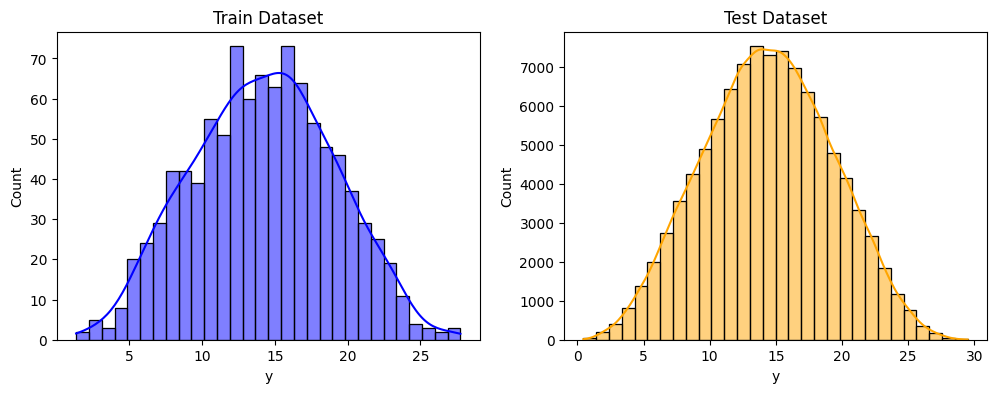

In [7]:
# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset')

sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset')

plt.show()

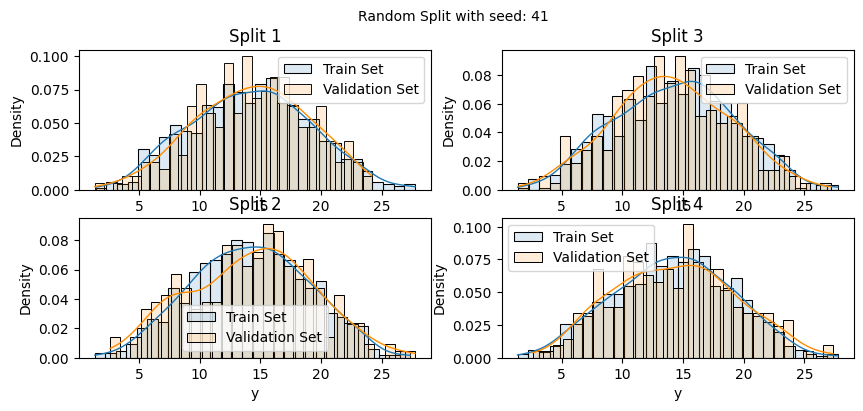

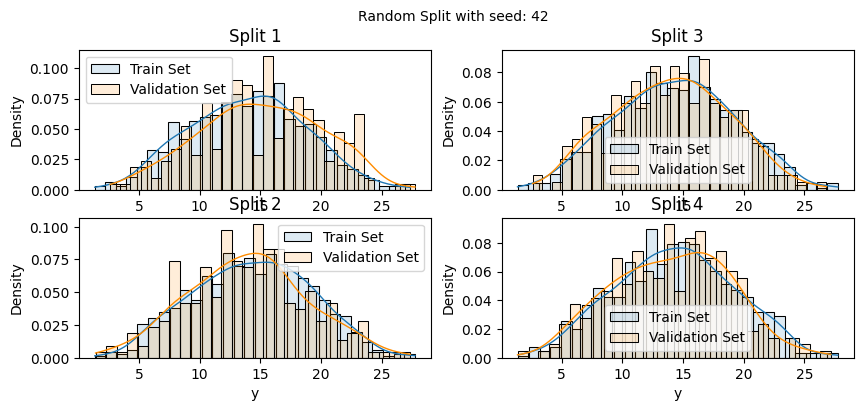

In [8]:
run_kfold_visualizer(labels=train.df.y, 
                     k=4,
                     seeds=[41, 42])

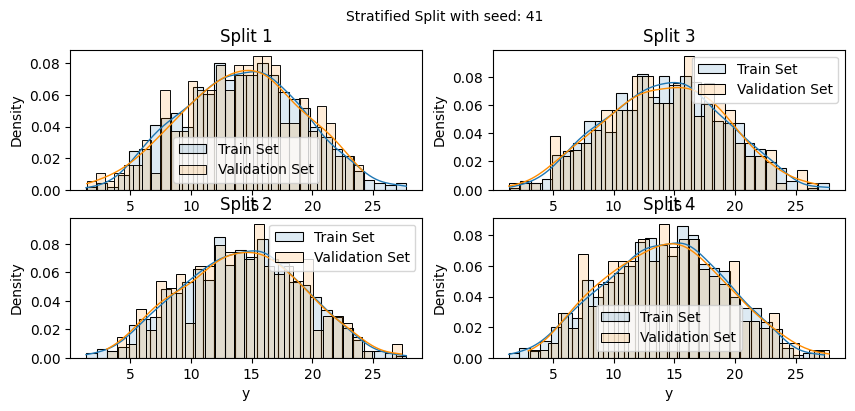

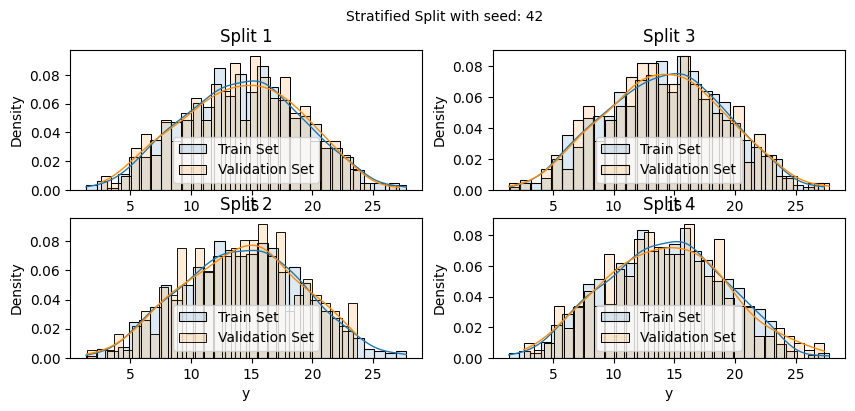

In [9]:
run_kfold_visualizer(labels=train.df.y, 
                     k=4, 
                     seeds=[41, 42], 
                     stratified=True)

## Random Forest Regressor

In [10]:
model = RandomForestRegressor(random_state=42)  # Replace with your regression model
param_grid = {
    'n_estimators': np.arange(500, 1001), # fix auf 500
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, train.features.shape[1] + 1) # erstmal gleich lassen -> gleichverteilt, für Regression eher höhere Werte, bias Richtung höhere Werte, Verteilung samplem, 0-1 "abgeschnitte NV"
} # Replace with your actual parameter grid

model_optimizer = ModelOptimizer(model, param_grid)

In [11]:
unstratified_results, stratified_results = model_optimizer.optimize(train.features,  #@nadja: andersherum
                                                                    train.y, 
                                                                    test.features,
                                                                    test.y,
                                                                    cv=5, 
                                                                    n_groups=20,
                                                                    scoring='neg_mean_squared_error', 
                                                                    n_jobs=-1, 
                                                                    n_iter=n_iter)

Best Parameters: {'n_estimators': 661, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 2}
Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [12]:
unstratified_results


{'train r2': 0.9173,
 'test r2': 0.8627,
 'train mse': 1.9305,
 'test mse': 3.259,
 'train mae': 1.0948,
 'test mae': 1.4257}

In [13]:
unstratified_results

{'train r2': 0.9173,
 'test r2': 0.8627,
 'train mse': 1.9305,
 'test mse': 3.259,
 'train mae': 1.0948,
 'test mae': 1.4257}

## Dummy Regressor

In [14]:
dummy_regressor = DummyRegressor(strategy="mean")
param_dummy = {}

dummy_optimizer = ModelOptimizer(dummy_regressor, param_dummy)


In [15]:
stratified_dummy, unstratified_dummy = dummy_optimizer.optimize(train.features, 
                                                                train.y, 
                                                                test.features,
                                                                test.y,
                                                                cv=5, 
                                                                n_groups=20,
                                                                scoring='neg_mean_squared_error', 
                                                                n_jobs=-1, 
                                                                n_iter=n_iter)

Best Parameters: {}
Best Parameters: {}


c:\Users\anneg\miniconda3\envs\slds\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\anneg\miniconda3\envs\slds\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# Imbalanced datasets

### Log transformation

In [16]:
train_log = FriedmanDataset(n_samples=n_train, 
                            n_features=5, 
                            noise=0.0, 
                            random_state=42)
train_log.transform(transformation='log')

In [17]:
test_log = FriedmanDataset(n_samples=n_test,
                           n_features=5,
                           noise=0.0,
                           random_state=1718)
test_log.transform(transformation='log')

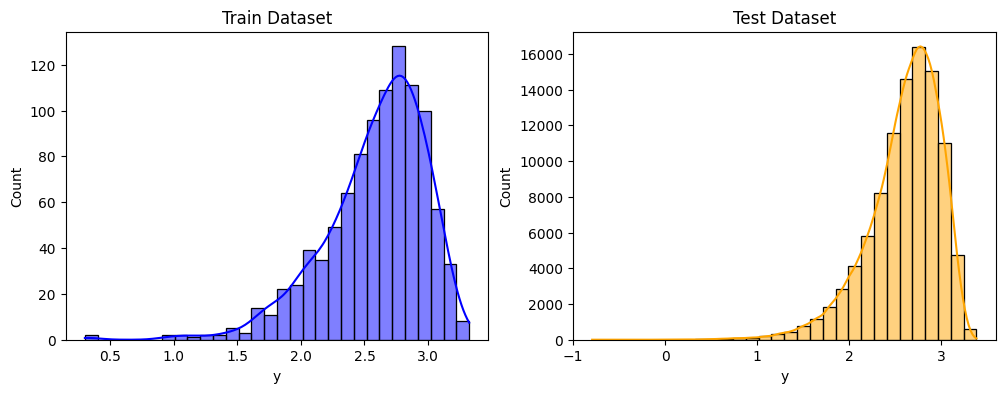

In [18]:
# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train_log.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset')

sns.histplot(test_log.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset')

plt.show()

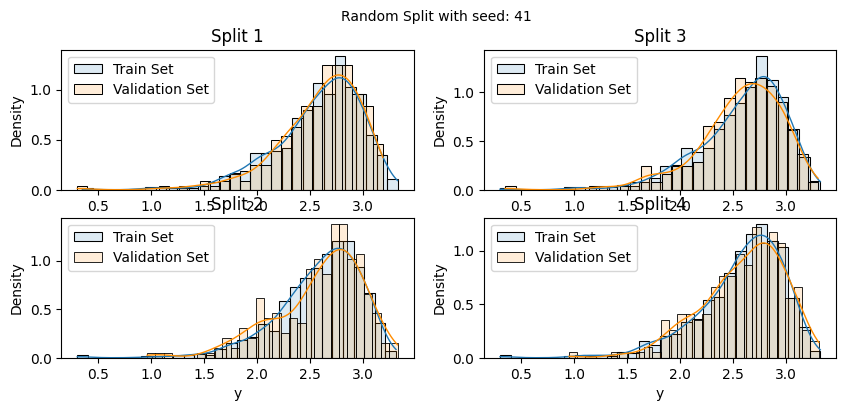

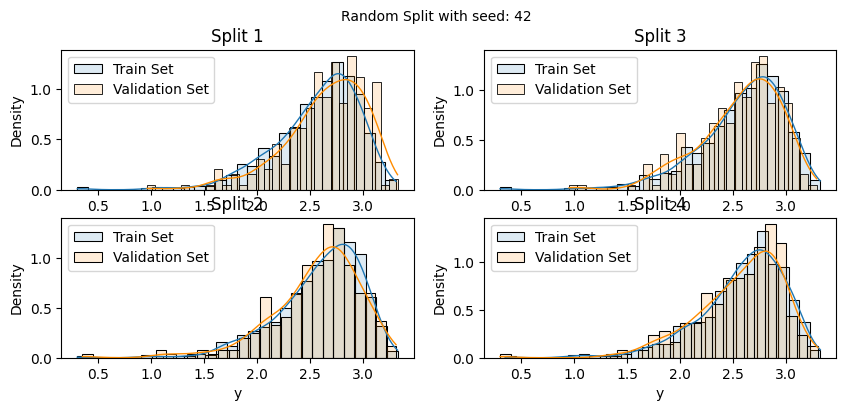

In [19]:
run_kfold_visualizer(labels=train_log.df.y, 
                     k=4,
                     seeds=[41, 42])

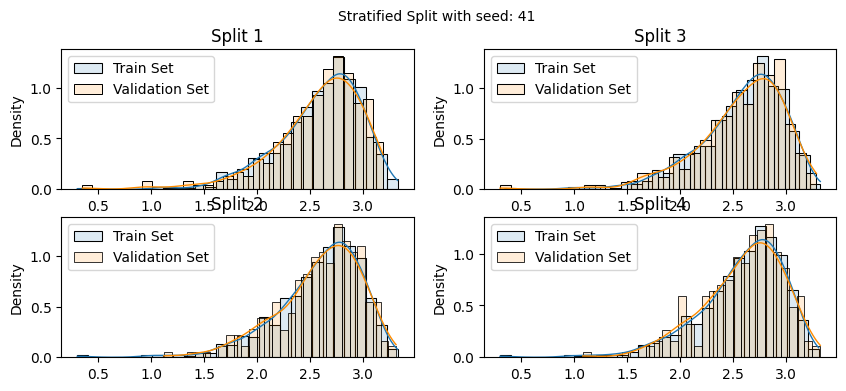

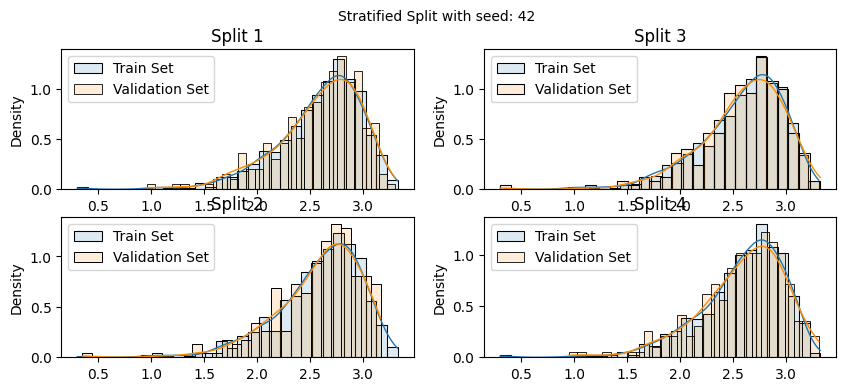

In [20]:
run_kfold_visualizer(labels=train_log.y, 
                     k=4,
                     seeds=[41, 42],
                     stratified=True)

In [21]:
# Define the parameter grid for random search
param_rf_log = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, train_log.features.shape[1] + 1)
}

rf_optimizer_log = ModelOptimizer(RandomForestRegressor(random_state=42), param_rf_log)




In [22]:
rf_random_log, rf_stratified_log=rf_optimizer_log.optimize(train_log.features, 
                                                           train_log.y,
                                                           test_log.features,
                                                           test_log.y,
                                                           cv=5, 
                                                           n_groups=20,
                                                           scoring='neg_mean_squared_error', 
                                                           n_jobs=-1,
                                                           n_iter=n_iter,
                                                           transformation='log')

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}
Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [23]:
print(train_log.df.head())
print(test_log.df.head())

         X1        X2        X3        X4        X5         y
0  0.374540  0.950714  0.731994  0.598658  0.156019  2.823654
1  0.155995  0.058084  0.866176  0.601115  0.708073  2.527154
2  0.020584  0.969910  0.832443  0.212339  0.181825  1.769802
3  0.183405  0.304242  0.524756  0.431945  0.291229  2.019145
4  0.611853  0.139494  0.292145  0.366362  0.456070  2.246795
         X1        X2        X3        X4        X5         y
0  0.127779  0.371794  0.090506  0.569015  0.279289  2.478827
1  0.167278  0.822057  0.929214  0.196677  0.478675  2.504022
2  0.963845  0.592640  0.031768  0.190911  0.483421  2.915705
3  0.115855  0.547358  0.899269  0.926827  0.968901  2.959076
4  0.142651  0.518969  0.560015  0.498482  0.877513  2.463791


In [24]:
print("Best Parameters (Stratified):", rf_stratified_log)
print("Best Parameters (Unstratified):", rf_random_log)

Best Parameters (Stratified): {'train r2': 0.9032, 'test r2': 0.8387, 'train mse': 0.0156, 'test mse': 0.0257, 'train mae': 0.0865, 'test mae': 0.1163}
Best Parameters (Unstratified): {'train r2': 0.9032, 'test r2': 0.8387, 'train mse': 0.0156, 'test mse': 0.0257, 'train mae': 0.0865, 'test mae': 0.1163}


In [25]:
rf_random_log = rf_optimizer_log._perform_optimization(train_log.features, train_log.y, test_log.features, test_log.y, 5, 20, 'neg_mean_squared_error', -1, 10, stratified=False)


Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [26]:
rf_stratified_log = rf_optimizer_log._perform_optimization(train_log.features, train_log.y, test_log.features, test_log.y, 5, 20, 'neg_mean_squared_error', -1, 10, stratified=True)


Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


WARUUUUUM????? Vielleicht weil Verteilungen sehr ähnlich?

In [27]:
rf_random_log

({'train r2': 0.9032,
  'test r2': 0.8387,
  'train mse': 0.0156,
  'test mse': 0.0257,
  'train mae': 0.0865,
  'test mae': 0.1163},
 {'n_estimators': 882,
  'min_samples_split': 14,
  'min_samples_leaf': 8,
  'max_features': 4})

In [28]:
rf_stratified_log

({'train r2': 0.9032,
  'test r2': 0.8387,
  'train mse': 0.0156,
  'test mse': 0.0257,
  'train mae': 0.0865,
  'test mae': 0.1163},
 {'n_estimators': 882,
  'min_samples_split': 14,
  'min_samples_leaf': 8,
  'max_features': 4})

### Sqrt transformation

In [29]:
train_sqrt = FriedmanDataset(n_samples=n_train, 
                            n_features=5, 
                            noise=0.0, 
                            random_state=42)
train_sqrt.transform(transformation='sqrt')

In [30]:
test_sqrt = FriedmanDataset(n_samples=n_test,
                           n_features=5,
                           noise=0.0,
                           random_state=1718)
test_sqrt.transform(transformation='sqrt')

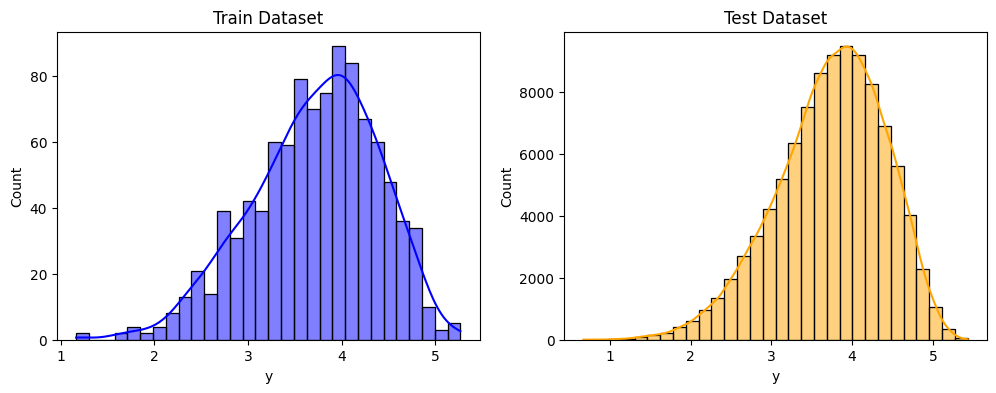

In [31]:
# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train_sqrt.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset')

sns.histplot(test_sqrt.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset')

plt.show()

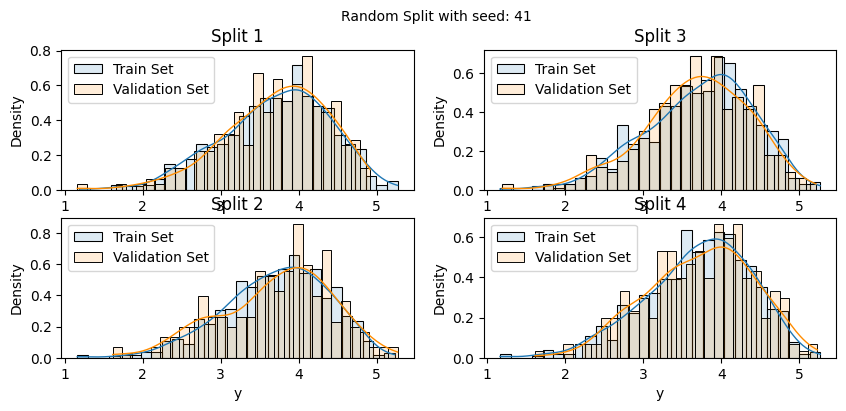

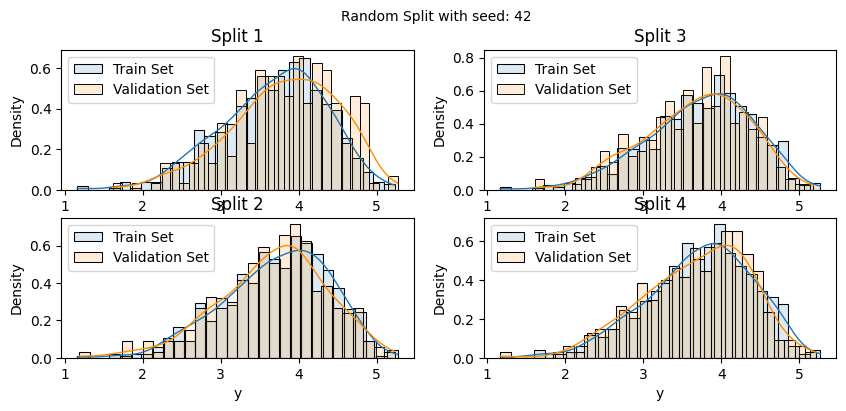

In [32]:
run_kfold_visualizer(labels=train_sqrt.df.y, 
                     k=4,
                     seeds=[41, 42])

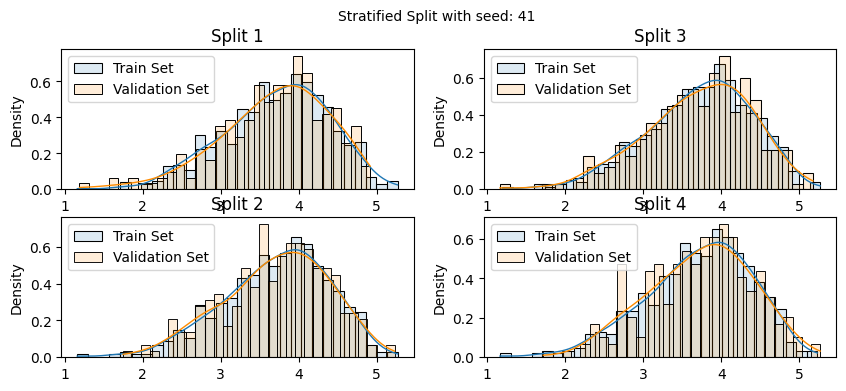

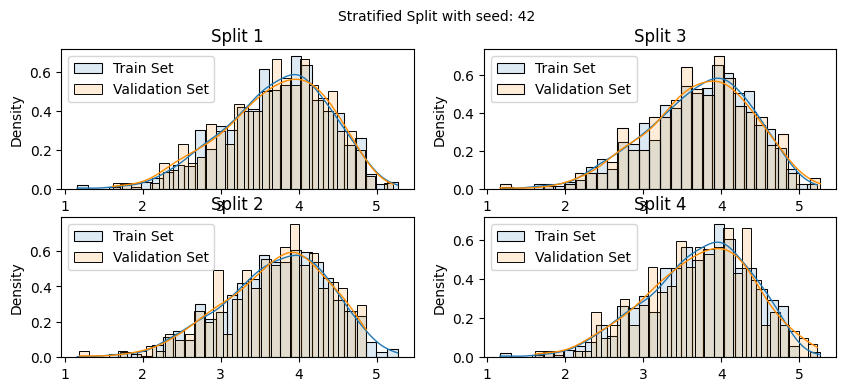

In [33]:
run_kfold_visualizer(labels=train_sqrt.y, 
                     k=4,
                     seeds=[41, 42],
                     stratified=True)

In [34]:
# Define the parameter grid for random search
param_rf_sqrt = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, train_sqrt.features.shape[1] + 1)
}

rf_optimizer_sqrt = ModelOptimizer(RandomForestRegressor(random_state=42), param_rf_sqrt)


In [35]:
rf_random_sqrt, rf_stratified_sqrt=rf_optimizer_sqrt.optimize(train_sqrt.features, 
                                                           train_sqrt.y,
                                                           test_sqrt.features,
                                                           test_sqrt.y,
                                                           cv=5, 
                                                           n_groups=20,
                                                           scoring='neg_mean_squared_error', 
                                                           n_jobs=-1,
                                                           n_iter=n_iter,
                                                           transformation='sqrt')

Best Parameters: {'n_estimators': 661, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 2}
Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [36]:
# scores sometime the same... dont really know why at the moment.

It's either the code or something else... here are some suggestions by ChatGPT, maybe we should check them out.
1. Parameter Grids:
Make sure that the parameter grids used for unstratified and stratified searches are indeed different. It's possible that the specified parameter grids are leading to similar or identical best parameters.

2. Data Transformation:
Verify that the data transformation is correctly applied to both training and test sets during the optimization process. If there's an issue with data transformation, it might result in consistent performance across different transformations.

3. Random Search Initialization:
RandomizedSearchCV initializes its random search with a random set of parameters. If the search space is not diverse enough or if the number of iterations is low, it might converge to similar parameter sets.

4. Evaluation Metric:
Ensure that the evaluation metric used in the optimization (neg_mean_squared_error in your case) is suitable for your problem. It's also essential to use the same metric consistently.

5. Model Complexity:
RandomForestRegressor might not be very sensitive to changes in certain hyperparameters, leading to similar performance across different parameter sets.

To further investigate, consider the following steps:

Increase the number of iterations (n_iter) to see if the random search explores a wider range of hyperparameters.
Simplify the problem by using a smaller dataset or a smaller parameter grid to debug and identify any unexpected behavior.